# **Import Libraries**

In [271]:
!pip install scikeras


In [272]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import keras


from datetime import datetime

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder as le

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.utils import resample
from sklearn.metrics import roc_auc_score, roc_curve, classification_report

from scikeras.wrappers import KerasClassifier
from keras.models import Sequential
from keras.layers import Dense,Dropout
from keras.callbacks import EarlyStopping
from keras.optimizers import RMSprop, Adam
from keras.regularizers import L2


In [290]:
from imblearn.over_sampling import SMOTE


# **Load Dataset**

In [2]:
from google.colab import files
uploaded = files.upload()

Saving data_test.csv to data_test.csv
Saving data_train.csv to data_train.csv


# **Set Train & Test Dataset**

In [149]:
train_dataset = pd.read_csv('data_train.csv')
test_dataset = pd.read_csv('data_test.csv')


<ipython-input-149-7b5b53cfee34>:1: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  train_dataset = pd.read_csv('data_train.csv')


In [150]:
train_dataset.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 28 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   ID                        100000 non-null  object 
 1   Customer_ID               100000 non-null  object 
 2   Month                     100000 non-null  object 
 3   Name                      90015 non-null   object 
 4   Age                       100000 non-null  object 
 5   SSN                       100000 non-null  object 
 6   Occupation                100000 non-null  object 
 7   Annual_Income             100000 non-null  object 
 8   Monthly_Inhand_Salary     84998 non-null   float64
 9   Num_Bank_Accounts         100000 non-null  int64  
 10  Num_Credit_Card           100000 non-null  int64  
 11  Interest_Rate             100000 non-null  int64  
 12  Num_of_Loan               100000 non-null  object 
 13  Type_of_Loan              88592 non-null   ob

In [151]:
print(train_dataset.shape)
print(train_dataset.head(5))

(100000, 28)
       ID Customer_ID     Month           Name   Age          SSN Occupation  \
0  0x1602   CUS_0xd40   January  Aaron Maashoh    23  821-00-0265  Scientist   
1  0x1603   CUS_0xd40  February  Aaron Maashoh    23  821-00-0265  Scientist   
2  0x1604   CUS_0xd40     March  Aaron Maashoh  -500  821-00-0265  Scientist   
3  0x1605   CUS_0xd40     April  Aaron Maashoh    23  821-00-0265  Scientist   
4  0x1606   CUS_0xd40       May  Aaron Maashoh    23  821-00-0265  Scientist   

  Annual_Income  Monthly_Inhand_Salary  Num_Bank_Accounts  ...  Credit_Mix  \
0      19114.12            1824.843333                  3  ...           _   
1      19114.12                    NaN                  3  ...        Good   
2      19114.12                    NaN                  3  ...        Good   
3      19114.12                    NaN                  3  ...        Good   
4      19114.12            1824.843333                  3  ...        Good   

   Outstanding_Debt Credit_Utilizatio

In [152]:
train_dataset.duplicated().sum()


np.int64(0)

In [153]:
train_dataset.isna().sum()


,0
ID,0
Customer_ID,0
Month,0
Name,9985
Age,0
SSN,0
Occupation,0
Annual_Income,0
Monthly_Inhand_Salary,15002
Num_Bank_Accounts,0


In [154]:
numeric_columns = train_dataset.select_dtypes(include=['number']).columns.tolist()
numeric_columns

['Monthly_Inhand_Salary',
 'Num_Bank_Accounts',
 'Num_Credit_Card',
 'Interest_Rate',
 'Delay_from_due_date',
 'Num_Credit_Inquiries',
 'Credit_Utilization_Ratio',
 'Total_EMI_per_month']

**Remove unwanted data**


In [155]:
train_dataset = train_dataset.drop(['ID', 'Name', 'SSN', 'Type_of_Loan'], axis=1)


In [156]:
train_dataset.drop(train_dataset[train_dataset["Occupation"]=='_______'].index,inplace=True)
train_dataset.drop(train_dataset[train_dataset["Credit_Mix"]=='_'].index,inplace=True)

In [157]:
train_dataset.info()


<class 'pandas.core.frame.DataFrame'>
Index: 74164 entries, 1 to 99999
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Customer_ID               74164 non-null  object 
 1   Month                     74164 non-null  object 
 2   Age                       74164 non-null  object 
 3   Occupation                74164 non-null  object 
 4   Annual_Income             74164 non-null  object 
 5   Monthly_Inhand_Salary     63052 non-null  float64
 6   Num_Bank_Accounts         74164 non-null  int64  
 7   Num_Credit_Card           74164 non-null  int64  
 8   Interest_Rate             74164 non-null  int64  
 9   Num_of_Loan               74164 non-null  object 
 10  Delay_from_due_date       74164 non-null  int64  
 11  Num_of_Delayed_Payment    68969 non-null  object 
 12  Changed_Credit_Limit      74164 non-null  object 
 13  Num_Credit_Inquiries      72692 non-null  float64
 14  Credit_Mix 

In [158]:
# Convert the credit_mix column to numerical values
train_dataset['Credit_Mix'] = train_dataset['Credit_Mix'].map({'Good': 2, 'Standard': 1, 'Bad': 0})

train_dataset['Credit_Mix'] = pd.to_numeric(train_dataset['Credit_Mix'], downcast='integer')

In [17]:
#train_dataset = pd.get_dummies(train_dataset, columns=['Occupation'])


In [159]:
train_dataset.head()

,Customer_ID,Month,Age,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
1,CUS_0xd40,February,23,Scientist,19114.12,NaN,3,4,3,4,...,2,809.98,31.944960,NaN,No,49.574949,118.28022162236736,Low_spent_Large_value_payments,284.62916249607184,Good
2,CUS_0xd40,March,-500,Scientist,19114.12,NaN,3,4,3,4,...,2,809.98,28.609352,22 Years and 3 Months,No,49.574949,81.699521264648,Low_spent_Medium_value_payments,331.2098628537912,Good
3,CUS_0xd40,April,23,Scientist,19114.12,NaN,3,4,3,4,...,2,809.98,31.377862,22 Years and 4 Months,No,49.574949,199.4580743910713,Low_spent_Small_value_payments,223.45130972736786,Good
4,CUS_0xd40,May,23,Scientist,19114.12,1824.843333,3,4,3,4,...,2,809.98,24.797347,22 Years and 5 Months,No,49.574949,41.420153086217326,High_spent_Medium_value_payments,341.48923103222177,Good
5,CUS_0xd40,June,23,Scientist,19114.12,NaN,3,4,3,4,...,2,809.98,27.262259,22 Years and 6 Months,No,49.574949,62.430172331195294,!@9#%8,340.4792117872438,Good


## **Data Clean and Impute**

In [160]:
train_dataset.isna().sum()


,0
Customer_ID,0
Month,0
Age,0
Occupation,0
Annual_Income,0
Monthly_Inhand_Salary,11112
Num_Bank_Accounts,0
Num_Credit_Card,0
Interest_Rate,0
Num_of_Loan,0


1.**Monthly_Inhand_Salary**


In [161]:
train_dataset['Monthly_Inhand_Salary'] = train_dataset.groupby('Customer_ID')['Monthly_Inhand_Salary'].transform(lambda v: v.mean())
train_dataset['Monthly_Inhand_Salary'] = train_dataset['Monthly_Inhand_Salary'].astype('float')

In [162]:
train_dataset['Monthly_Inhand_Salary'].isna().sum()

np.int64(15)

In [163]:
mean_value = train_dataset['Monthly_Inhand_Salary'].mean()
train_dataset['Monthly_Inhand_Salary'] = train_dataset['Monthly_Inhand_Salary'].fillna(mean_value)

In [164]:
train_dataset['Monthly_Inhand_Salary'].isna().sum()


np.int64(0)


2. **Num_of_Delayed_Payment**


In [165]:
train_dataset['Num_of_Delayed_Payment'] = train_dataset.groupby('Customer_ID')['Num_of_Delayed_Payment'].transform(lambda v: v.ffill().bfill())


In [166]:
train_dataset['Num_of_Delayed_Payment'].isna().sum()


np.int64(0)

3. **Num_Credit_Inquiries**

In [167]:
# Update the offset values with the median of the customers cummulative values
px = train_dataset.copy()

d1 = px['Num_Credit_Inquiries']
print(d1.describe())

px.loc[(px['Num_Credit_Inquiries'] > 20), 'Num_Credit_Inquiries'] = np.nan
px['Num_Credit_Inquiries'] = px['Num_Credit_Inquiries'].fillna(train_dataset['Num_Credit_Inquiries'].median())

d2 = px['Num_Credit_Inquiries']
train_dataset.update(px)

count    72692.000000
mean        27.588593
std        192.411625
min          0.000000
25%          3.000000
50%          6.000000
75%          9.000000
max       2597.000000
Name: Num_Credit_Inquiries, dtype: float64


In [168]:
train_dataset['Num_Credit_Inquiries'].isna().sum()

np.int64(0)

4. **Credit_History_Age**

In [169]:
def cal_history_age(val):
  try:
    year, month = 0, 0
    if re.search('year', val, re.IGNORECASE):
      year = int(re.findall('\d+', val)[0])
    if re.search('month', val, re.IGNORECASE):
      month = int(re.findall('\d+', val)[1])
    return year*12+month
  except:
    return np.nan

In [170]:
train_dataset['Credit_History_Age'] = train_dataset['Credit_History_Age'].apply(cal_history_age)
train_dataset['Credit_History_Age'] = train_dataset.groupby('Customer_ID')['Credit_History_Age'].transform(lambda v: v.ffill())
train_dataset['Credit_History_Age'] = train_dataset.groupby('Customer_ID')['Credit_History_Age'].transform(lambda v: v.bfill())
train_dataset['Credit_History_Age'] = train_dataset['Credit_History_Age'].astype('float')

In [171]:
train_dataset['Credit_History_Age'].isna().sum()


np.int64(3)

In [172]:
credit_mean=train_dataset["Credit_History_Age"].mean()
train_dataset["Credit_History_Age"].fillna(credit_mean, inplace=True)


<ipython-input-172-a5c2b0c2c315>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_dataset["Credit_History_Age"].fillna(credit_mean, inplace=True)


In [173]:
train_dataset['Credit_History_Age'].isna().sum()


np.int64(0)

5. **Amount_invested_monthly**



In [174]:
def return_null(val):
  if isinstance(val, str) and "__" in val:
    return np.nan
  else:
    return val

In [175]:
train_dataset['Amount_invested_monthly'] = train_dataset['Amount_invested_monthly'].apply(return_null)
train_dataset['Amount_invested_monthly'] = train_dataset['Amount_invested_monthly'].astype('float')
train_dataset['Amount_invested_monthly'] = train_dataset.groupby('Customer_ID')['Amount_invested_monthly'].transform(lambda v: v.mean())

In [138]:
train_dataset['Amount_invested_monthly'].isna().sum()


np.int64(1)

In [176]:
invest_mean=train_dataset["Amount_invested_monthly"].mean()
train_dataset["Amount_invested_monthly"].fillna(invest_mean, inplace=True)

<ipython-input-176-8cb0f7481914>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_dataset["Amount_invested_monthly"].fillna(invest_mean, inplace=True)


In [177]:
train_dataset['Amount_invested_monthly'].isna().sum()


np.int64(0)

6. **Monthly_Balance**

In [178]:
train_dataset['Monthly_Balance'] = train_dataset['Monthly_Balance'].apply(return_null)
train_dataset['Monthly_Balance'] = train_dataset['Monthly_Balance'].astype('float')
train_dataset['Monthly_Balance'] = train_dataset.groupby('Customer_ID')['Monthly_Balance'].transform(lambda v: v.mean())

In [179]:
train_dataset['Monthly_Balance'].isna().sum()


np.int64(2)

In [180]:
monthly_balance_mean=train_dataset["Monthly_Balance"].mean()
train_dataset["Monthly_Balance"].fillna(monthly_balance_mean, inplace=True)

<ipython-input-180-e57e96ce3990>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_dataset["Monthly_Balance"].fillna(monthly_balance_mean, inplace=True)


In [181]:
train_dataset['Monthly_Balance'].isna().sum()


np.int64(0)

7. **Payment_of_Min_Amount - Mapping**

In [182]:
pay_map={"Yes":1,"No":2,"NM":3}
train_dataset['Payment_of_Min_Amount'] = train_dataset['Payment_of_Min_Amount'].replace(pay_map)

<ipython-input-182-f4081fda9072>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_dataset['Payment_of_Min_Amount'] = train_dataset['Payment_of_Min_Amount'].replace(pay_map)


In [183]:
train_dataset["Payment_of_Min_Amount"].value_counts()


,count
Payment_of_Min_Amount,
1,38737
2,26501
3,8926


In [184]:
train_dataset['Payment_of_Min_Amount'].isna().sum()


np.int64(0)

In [119]:
# Convert the payment_of_min_amount column to numerical values
#train_dataset['Payment_of_Min_Amount'] = train_dataset['Payment_of_Min_Amount'].map({'Yes': 1, 'No': 0})

#train_dataset['Payment_of_Min_Amount'] = pd.to_numeric(train_dataset['Payment_of_Min_Amount'], downcast='integer')

In [145]:
#train_dataset['Credit_Mix'] = train_dataset.groupby('Customer_ID')['Credit_Mix'].transform(lambda x: x.fillna(x.mode()[0]))

8. **Payment_Behavior**

In [185]:
train_dataset['Payment_Behaviour']

,Payment_Behaviour
1,Low_spent_Large_value_payments
2,Low_spent_Medium_value_payments
3,Low_spent_Small_value_payments
4,High_spent_Medium_value_payments
5,!@9#%8
...,...
99991,High_spent_Large_value_payments
99993,Low_spent_Medium_value_payments
99997,High_spent_Large_value_payments
99998,Low_spent_Large_value_payments


In [186]:
train_dataset['Payment_Behaviour']= train_dataset['Payment_Behaviour'].replace("!@9#%8",np.nan)


In [187]:
train_dataset["Payment_Behaviour"].value_counts()


,count
Payment_Behaviour,
Low_spent_Small_value_payments,18866
High_spent_Medium_value_payments,13075
Low_spent_Medium_value_payments,10304
High_spent_Large_value_payments,10191
High_spent_Small_value_payments,8341
Low_spent_Large_value_payments,7711


**Payment Behavior Mapping**

In [188]:
payment_mapping = {
    'High_spent_Large_value_payments': 6,#Successfully managing large debts provides the most positive contribution to the credit score.
    'High_spent_Medium_value_payments': 5, #Medium-value payments with high spending positively impact the credit score.
    'High_spent_Small_value_payments': 4, #Small payments can negatively affect the credit score if debts accumulate over time.
    'Low_spent_Large_value_payments': 3, #shows quick financial responsibility, positively affecting the credit score.
    'Low_spent_Medium_value_payments': 2, #contributes positively to the credit score by demonstrating debt management.
    'Low_spent_Small_value_payments': 1 #may limit the credit history and provide minimal contribution to the credit score
}


train_dataset['Payment_Behaviour'] = train_dataset['Payment_Behaviour'].map(payment_mapping)

train_dataset['Payment_Behaviour'] = pd.to_numeric(train_dataset['Payment_Behaviour'], downcast='integer')

In [189]:
train_dataset['Payment_Behaviour'].isna().sum()


np.int64(5676)

In [191]:
#train_dataset['Payment_Behaviour'] = train_dataset.groupby('Customer_ID')['Payment_Behaviour'].transform(lambda x: x.fillna(x.mode()[0]))
def safe_mode_fill(x):
    mode = x.mode()
    if not mode.empty:
        return x.fillna(mode[0])
    else:
        return x  # leave NaN as is if no mode exists

train_dataset['Payment_Behaviour'] = train_dataset.groupby('Customer_ID')['Payment_Behaviour'].transform(safe_mode_fill)

In [192]:
train_dataset['Payment_Behaviour'].isna().sum()


np.int64(4)

In [193]:
overall_mode = train_dataset['Payment_Behaviour'].mode()[0]
train_dataset['Payment_Behaviour'] = train_dataset['Payment_Behaviour'].fillna(overall_mode)

In [194]:
train_dataset['Payment_Behaviour'].isna().sum()


np.int64(0)

In [195]:
train_dataset["Payment_Behaviour"].value_counts()


,count
Payment_Behaviour,
1.0,21443
5.0,13950
2.0,11111
6.0,10770
4.0,8748
3.0,8142


**Month Mapping**

In [196]:
month_map = {
    'January': 1,
    'February': 2,
    'March': 3,
    'April': 4,
    'May': 5,
    'June': 6,
    'July': 7,
    'August': 8,
    'September': 9,
    'October': 10,
    'November': 11,
    'December': 12
}

#Mapping
train_dataset['Month'] = train_dataset['Month'].map(month_map)

train_dataset['Month'] = pd.to_numeric(train_dataset['Month'], downcast='integer')

In [197]:
train_dataset.isna().sum()


,0
Customer_ID,0
Month,0
Age,0
Occupation,0
Annual_Income,0
Monthly_Inhand_Salary,0
Num_Bank_Accounts,0
Num_Credit_Card,0
Interest_Rate,0
Num_of_Loan,0


In [198]:
train_dataset.head()

,Customer_ID,Month,Age,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
1,CUS_0xd40,2,23,Scientist,19114.12,1824.843333,3,4,3,4,...,2,809.98,31.944960,267.0,2,49.574949,100.916775,3.0,303.42118,Good
2,CUS_0xd40,3,-500,Scientist,19114.12,1824.843333,3,4,3,4,...,2,809.98,28.609352,267.0,2,49.574949,100.916775,2.0,303.42118,Good
3,CUS_0xd40,4,23,Scientist,19114.12,1824.843333,3,4,3,4,...,2,809.98,31.377862,268.0,2,49.574949,100.916775,1.0,303.42118,Good
4,CUS_0xd40,5,23,Scientist,19114.12,1824.843333,3,4,3,4,...,2,809.98,24.797347,269.0,2,49.574949,100.916775,5.0,303.42118,Good
5,CUS_0xd40,6,23,Scientist,19114.12,1824.843333,3,4,3,4,...,2,809.98,27.262259,270.0,2,49.574949,100.916775,1.0,303.42118,Good


## **Age Fix**

In [235]:
def fix_age(x):
  if x > 100 or x <=0:
    return np.nan
  return x

In [236]:
train_dataset['Age'] = train_dataset['Age'].apply(lambda x: x if x is np.nan or not isinstance(x, str)
                    else x.replace("_","")).replace("",np.nan)
train_dataset['Age'] = train_dataset['Age'].astype('float')

In [239]:
train_dataset['Age'] = train_dataset['Age'].apply(fix_age)


In [237]:
train_dataset['Age'].isna().sum()


np.int64(2060)

In [243]:
mean_age = int(round(train_dataset['Age'].mean()))
train_dataset['Age'] = train_dataset['Age'].fillna(mean_age).astype(int)

In [244]:
train_dataset['Age'].isna().sum()


np.int64(0)

## **Occupation Mapping**

In [245]:
occupation_mapping = {
    'Lawyer': 1,
    'Architect': 2,
    'Engineer': 3,
    'Scientist': 4,
    'Mechanic': 5,
    'Accountant': 6,
    'Developer': 7,
    'Media_Manager': 8,
    'Teacher': 9,
    'Entrepreneur': 10,
    'Doctor': 11,
    'Journalist': 12,
    'Manager': 13,
    'Musician': 14,
    'Writer': 15
}

train_dataset['Occupation'] = train_dataset['Occupation'].replace(occupation_mapping)


## **Set X, Y values**

In [292]:
# Separate features and target variable
Xx = train_dataset.drop("Credit_Score", axis=1)
yy = train_dataset.Credit_Score

In [293]:
yy.value_counts(normalize=True) # unbalanced data  2:Good, 1: Standard, 0: Poor


,proportion
Credit_Score,
Standard,0.531808
Poor,0.290019
Good,0.178173


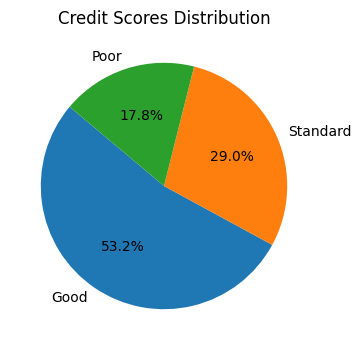

In [247]:
plt.figure(figsize=(4, 4))
plt.pie(train_dataset['Credit_Score'].value_counts(), labels=train_dataset['Credit_Score'].unique(), autopct='%1.1f%%', startangle=140)
plt.title('Credit Scores Distribution')
plt.show()

In [249]:
train_dataset["Credit_Score"].value_counts(normalize = True) # 2:Good, 1: Standard, 0: Poor


,proportion
Credit_Score,
Standard,0.531808
Poor,0.290019
Good,0.178173


In [250]:
train_dataset.shape


(74164, 24)

**Backup training dataset**

In [259]:
train_copy = train_dataset.copy()
train_copy2= train_dataset.copy()


In [262]:
train_copy.shape


(74164, 24)

In [263]:
train_copy.isna().sum()


,0
Customer_ID,0
Month,0
Age,0
Occupation,0
Annual_Income,0
Monthly_Inhand_Salary,0
Num_Bank_Accounts,0
Num_Credit_Card,0
Interest_Rate,0
Num_of_Loan,0


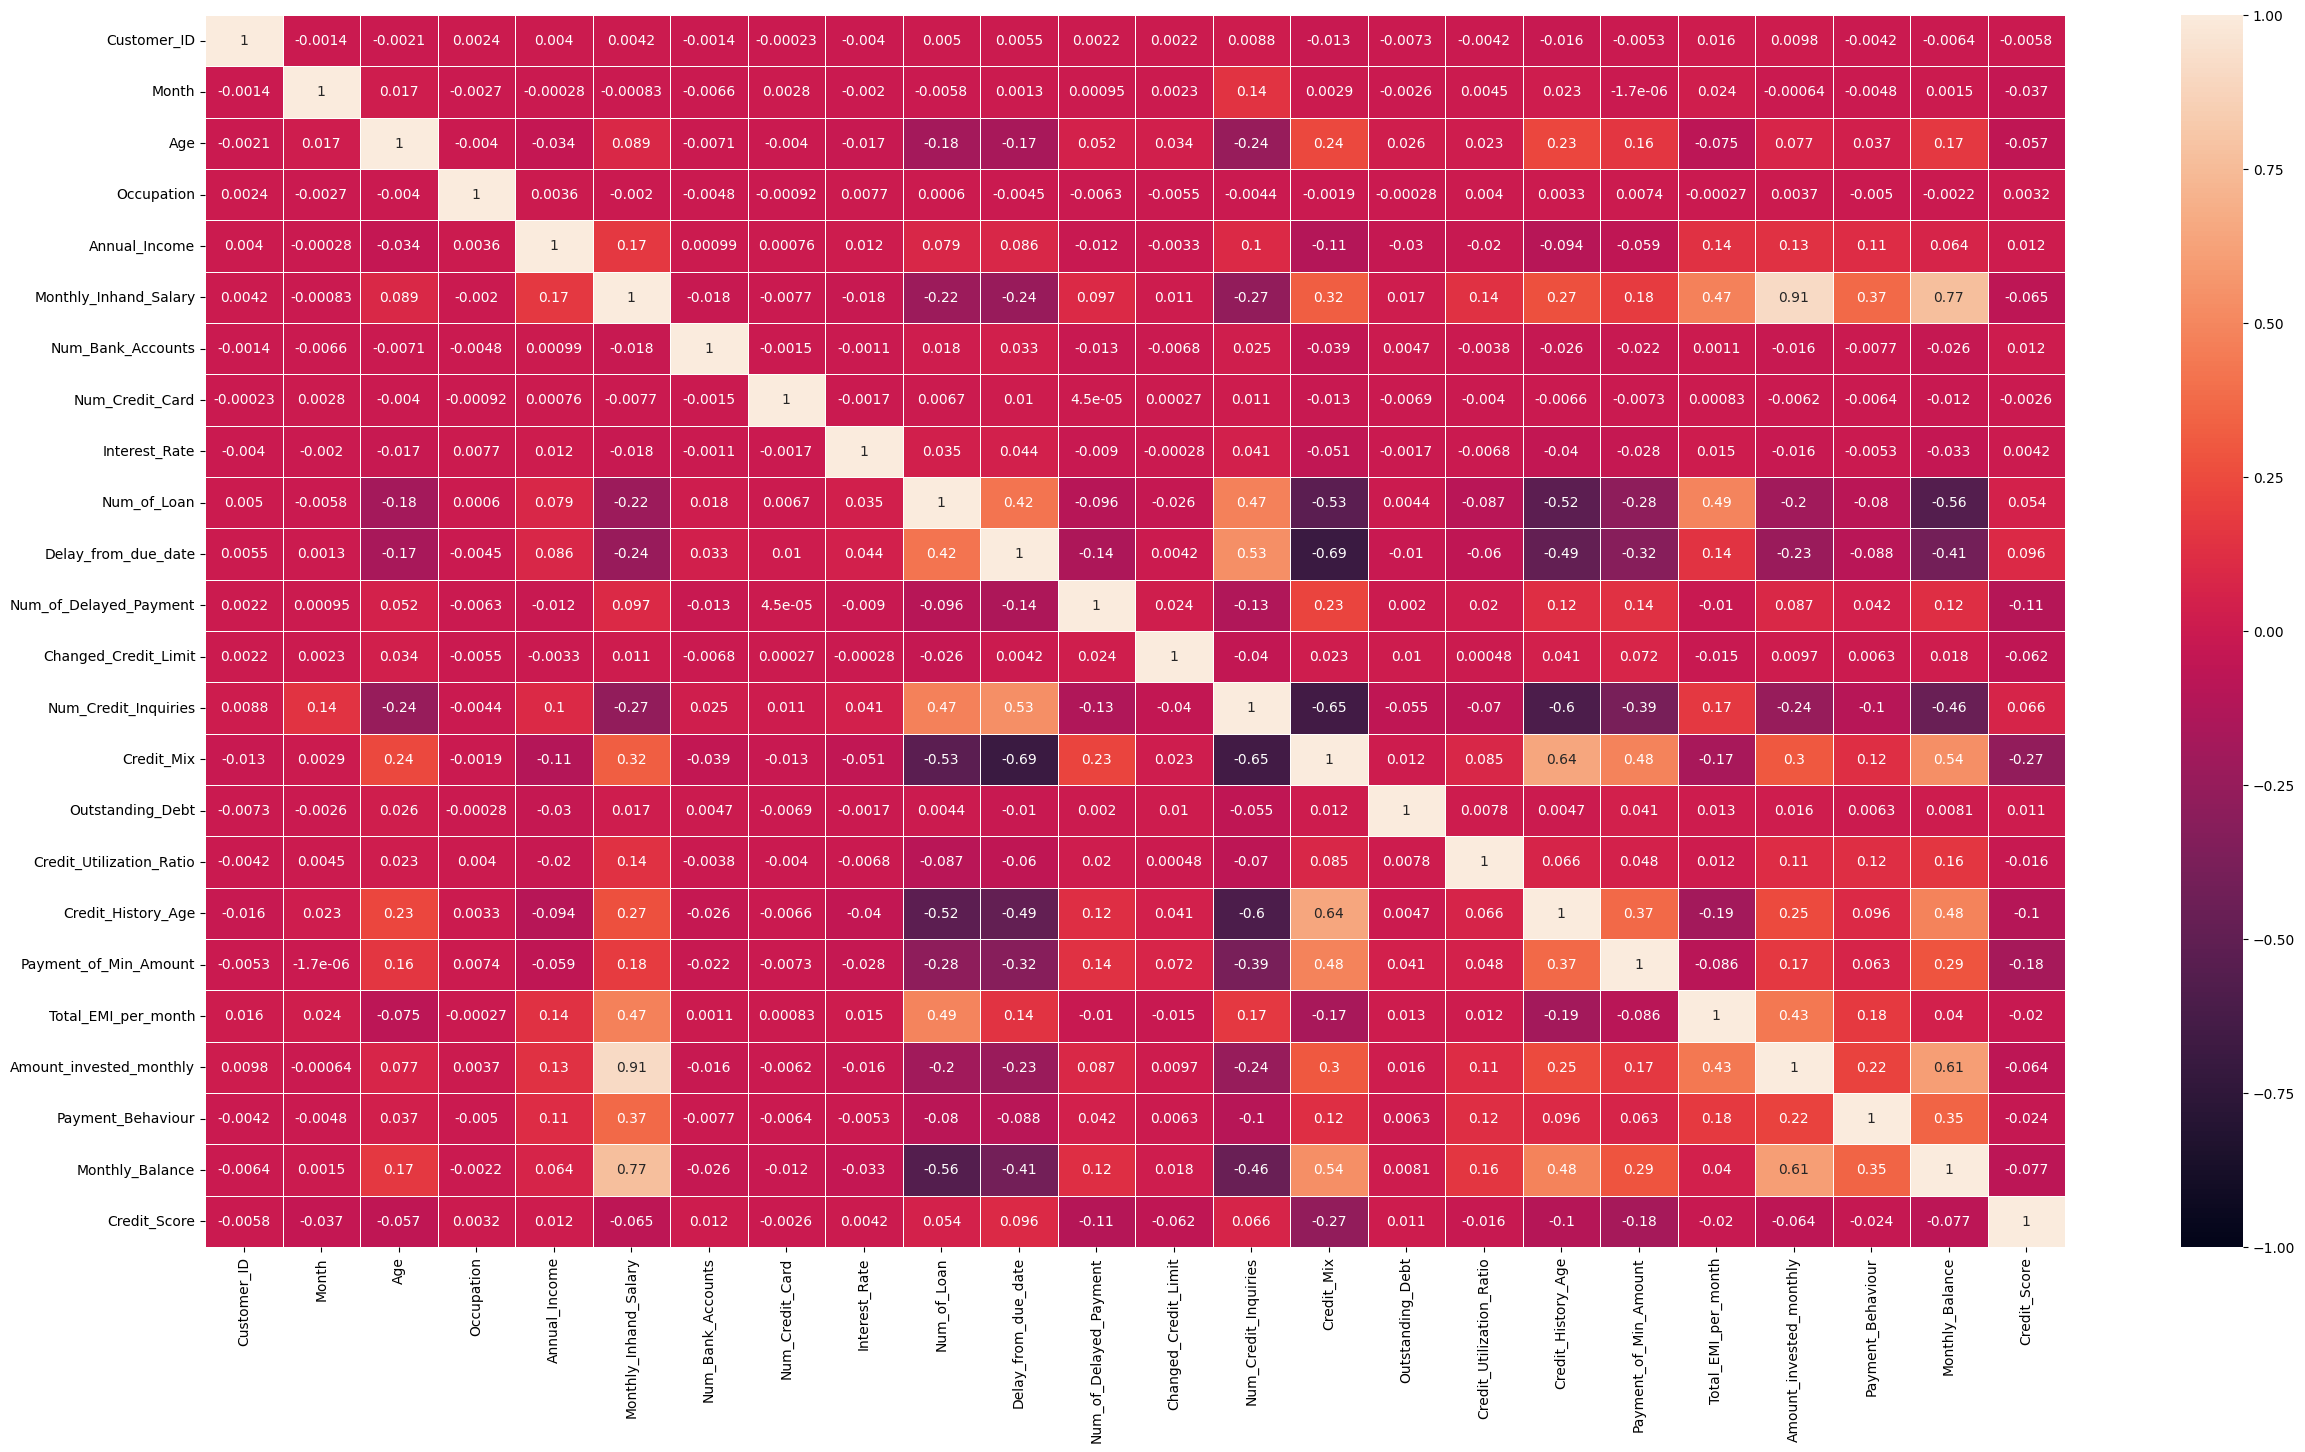

In [264]:

dx = train_copy.copy()

for c in dx.columns:
  dx[c] = le().fit_transform(dx[c])

plt.figure(figsize=(30, 16))
sns.heatmap(dx.corr(), linewidths=.5, annot=True, vmax=1, vmin=-1)
plt.show()

# **Model Training**

In [294]:
Xx.shape


(74164, 23)

In [295]:
yy.value_counts()


,count
Credit_Score,
Standard,39441
Poor,21509
Good,13214


In [304]:
X_train, X_test, y_train, y_test = train_test_split(Xx, yy, test_size=0.20,
                                                    stratify=yy, random_state=42)

In [305]:

print("X_train : ", np.shape(X_train))
print("X_test  : ", np.shape(X_test))

X_train :  (59331, 23)
X_test  :  (14833, 23)


In [306]:
print("y_train : ", np.shape(y_train))


y_train :  (59331,)


In [301]:
model=Sequential()
model.add(Dense(128, input_dim=X_train.shape[1], activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(3, activation="softmax"))
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

es=EarlyStopping(monitor="val_accuracy",patience=20,mode="max",verbose=1)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
